In [27]:
import pandas as pd
import numpy as np
from pathlib import Path
from functools import reduce
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means

from sklearn.model_selection import train_test_split
import xgboost as xgb

import plotly.express as px
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

import matplotlib.gridspec as gridspec
from scipy.stats import norm
from matplotlib.ticker import FuncFormatter

In [2]:
TIME_FORMAT = '%Y-%m-%d'
key_columns = ['locus_id', 'fish_group_id', 'transfer_year']
root_path = Path('./data/')

mortality = pd.read_csv('../data/smolt_dataset_transfers_until2023Feb28_narrow.csv')
mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
mortality['transport_year']= mortality['transfer_date'].dt.year
tgc = pd.read_csv('../data/transfers_until2023Feb28_with_sw_growth_targets.csv')
targets =pd.read_csv('../data/targets.csv')

In [3]:
root_path_predictive = 'result_data/predictive/importance/'

df1=pd.read_csv(root_path_predictive+'nsfr_features_summary.csv',encoding='windows-1252')
df2=pd.read_csv(root_path_predictive+'log_mortality_features_summary.csv',encoding='windows-1252')
df1.columns = ['factor','IV','corr with nSFR']
df2.columns = ['factor','IV','corr with mortality']

In [4]:
root_path2='result_data/factor_ranking/'

df_nan=pd.read_csv(root_path2+'features_with_high_nan_zeros1719.csv')
df_nan.columns=['factor']
df_nan['nan_flag'] = 1

# df=df[:10]

In [5]:
# df=df1.merge(df2, on=['factor','corr with mortality','corr with nSFR'],how='outer')
df=df1.merge(df2, on=['factor'],how='outer')
df['IV_x']=df['IV_x'].fillna(df['IV_x'].min())
df['IV_y']=df['IV_y'].fillna(df['IV_y'].min())
df['IV'] = 1/2*(df['IV_x']+df['IV_y'])
df_sorted=df.sort_values(by='IV',ascending=False).reset_index(drop=True)

In [49]:
df_sorted.to_csv(root_path2+'smolt_quality_final_features_importance.csv',index=False,encoding='windows-1252')

In [6]:
df=df.merge(df_nan,how='left')
factor_list_nonnan=df[df.nan_flag.isna()].factor
df.sort_values(by='IV',ascending=False).reset_index(drop=True)

,factor,IV_x,corr with nSFR,IV_y,corr with mortality,IV,nan_flag
0,temperature_fw_sw_diff,0.194134,-0.237180,0.046992,0.201705,0.120563,NaN
1,atpasa_derivative,0.138630,0.142034,0.028755,NaN,0.083693,1.0
2,number_of_weeks_with_summer_vac_transfer,0.009929,NaN,0.138629,0.124851,0.074279,1.0
3,temperature_cleared-before_first_feeding-mean,0.050325,0.013996,0.082634,0.174179,0.066479,NaN
4,is_luf_weighted,0.088851,0.090367,0.043268,0.061349,0.066059,NaN
5,fw_cycle_length_first_mvmt_shipout,0.061330,-0.092679,0.043132,-0.019908,0.052231,NaN
6,temperature_cleared-before_first_feeding-degre...,0.039094,-0.037005,0.063762,-0.114564,0.051428,NaN
7,is_nacl-whole_period-sum,0.064480,0.205882,0.033546,0.052975,0.049013,NaN
8,is_nacl-after_first_feeding-sum,0.039836,0.149262,0.043224,-0.137388,0.041530,NaN
9,mortality_rate-after_first_feeding-sum_Desadap...,0.025819,0.087506,0.053868,-0.200142,0.039844,NaN


In [7]:
result_data_path = Path('./result_data')
path_data = result_data_path / 'main' / 'factors_main.csv'
factors = pd.read_csv(path_data,encoding='windows-1252')

In [58]:
# nan_key = factors_luf[factors_luf['is_luf_weighted'].isna()][key_columns]
# factors = factors_treatment\
# .merge(factors_sfr, on=key_columns, how='left')\
# .merge(factors_cycle, on=key_columns, how='left')\
# .merge(factors_transfer, on=key_columns, how='left')\
# .merge(factors_producer, on=key_columns, how='left')\
# .merge(factors_mortality, on=key_columns, how='left')\
# .merge(factors_mortality_reasons, on=key_columns, how='left')\
# .merge(factors_luf, on=key_columns, how='left')\
# .merge(factors_temperature, on=key_columns, how='left')\
# .merge(factors_feed_1, on=key_columns, how='left')\
# .merge(factors_feed_2, on=key_columns, how='left')\
# .merge(factors_feed_3, on=key_columns, how='left')\
# .merge(factors_ammonium, on=key_columns, how='left')\
# .merge(factors_recambio, on=key_columns, how='left')\
# .merge(factors_ph, on=key_columns, how='left')\
# .merge(factors_lab, on=key_columns, how='left')\
# .merge(factors_photoperiod, on=key_columns, how='left')\
# .merge(factors_vaccination, on=key_columns, how='left')\
# .merge(factors_gender, on=key_columns, how='left')



# print(f'{factors.isna().sum()}\n out of {factors.shape[0]}')

locus_id                                     0
fish_group_id                                0
transfer_year                                0
is_baño sin pmv-after_first_feeding-sum    273
is_baño sin pmv-whole_period-sum           273
                                          ... 
main_gender_H                                0
main_gender_M                                0
dominating_gender_H                          0
dominating_gender_M                          0
dominating_gender_non_existing               0
Length: 74, dtype: int64
 out of 1262


In [59]:
# factors_dfs = [
#     factors_ammonium,
#     factors_feed_1,
#     factors_feed_2,
#     factors_feed_3,
#     factors_luf,
#     factors_mortality,
#     factors_mortality_reasons,
#     factors_ph,
#     factors_producer,
#     factors_recambio,
#     factors_sfr,
#     factors_temperature
# ]

# factors = reduce(lambda left, right: pd.merge(left, right, on=key_columns, how='left'), factors_dfs)

In [13]:
factors_targets = factors.merge(
    mortality[key_columns + ['total_mortality_perc_90']],
    on=key_columns,
    how='inner'
).merge(
    targets[key_columns + ['TGC_SW','nSFR']],
    on=key_columns,
    how='inner'
)

factors_targets.drop(key_columns, inplace=True, axis=1)
factors_targets.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)
factors_targets.rename(columns={'TGC_SW': 'tgc'}, inplace=True)
# factors_targets = factors_targets.join(pd.get_dummies(factors_targets['dominating_producer'], drop_first=True))
# factors_targets = factors_targets.join(pd.get_dummies(factors_targets['main_producer'], drop_first=True))
# factors_targets.drop('dominating_producer', axis=1, inplace=True)
# factors_targets.drop('main_producer', axis=1, inplace=True)

In [14]:
# bc_medians=pd.read_csv('result_data/clustering/best_clusters_medians.csv')
bc_medians=pd.read_csv('result_data/clustering/best_clusters_full.csv')

bc_medians_=bc_medians.T
bc_medians_.columns=bc_medians_.iloc[0]
bc_medians__=bc_medians_.iloc[1:].reset_index(drop=True)
tmp_data=bc_medians__[bc_medians__.cluster==4]
# median_value=tmp_data[factor_col+'_median'].iloc[0]
arr_cluster_names = bc_medians__.cluster[bc_medians__.cluster != 'all'].values

In [15]:
df_sorted.factor[:10]#[-1:].iloc[0]

0                               temperature_fw_sw_diff
1                                    atpasa_derivative
2             number_of_weeks_with_summer_vac_transfer
3        temperature_cleared-before_first_feeding-mean
4                                      is_luf_weighted
5                   fw_cycle_length_first_mvmt_shipout
6    temperature_cleared-before_first_feeding-degre...
7                             is_nacl-whole_period-sum
8                      is_nacl-after_first_feeding-sum
9    mortality_rate-after_first_feeding-sum_Desadap...
Name: factor, dtype: object

In [16]:
top_features = df_sorted.factor[:10]
# left_boundary = [0.5, 1, 13,.4,.03,.4,.03,21,3.5,.2,.6]
# right_boundary = [0.6, 2, 14,.5,.04,.6,.08,22,4.5,.4,.7]
left_boundary =  [1,  0.4, 3.5, 4, 0   , 450, 350, 0.5, 0.6, 0.03]
right_boundary = [2,  0.5, 4.5, 5, 0.02, 500, 400, 0.6, 0.7, 0.08]

optimal_ranges = {feature: (left, right) for feature, left, right in zip(top_features, left_boundary, right_boundary)}

In [17]:
factor_names_normal=[
'Temperature difference between FW and SW : Last 14 days in FW and first 14 days in SW',
'Average daily change of ATPase : Last 2-6 weeks before transfer',
'Number of weeks with summer photoperiod : Vaccination - Transfer',
'Average temperature : Incubation (before first feeding)',
'Relative amount of feed given containing Lufenuron : Whole FW cycle',
'Whole FW cycle length, days : N/A',
'Degree*days : Incubation (before first feeding)',
'Relative number of days with NaCL treatment : Whole FW cycle',
'Relative number of days with NaCL treatment : First 4 weeks after first feeding',
'Mortality rate with "Desadaptado" reason : First 4 weeks after first feeding',
# 'Days in vaccination tanks after vaccination : N/A',
# 'Mortality rate with "Embrionaria" reason : Hatching - First feeding',
# 'Relative number of days with low SFR : Last 2 weeks before transfer',
# 'Ratio of fish with Male gender : N/A',
# 'Average temperature : First feeding - Transfer',
# 'ATPase before transfer : N/A',
# 'Relative number of days with low SFR : Last 4 weeks before transfer',
]

In [18]:
vis_path = '../modeling/img/clustering/'
font_size = 14

In [237]:
# i=1
# cluster_name= 4
# font_size = 14
# showfliers = True

# factor_col =df_sorted.factor[i]
# factor_data = factors_targets[factor_col]
# cluster_medians=bc_medians__[bc_medians__.cluster==cluster_name]
# if factor_col+'_median' in cluster_medians.columns:
#     cluster_value = cluster_medians[factor_col+'_median'].iloc[0]

# plt.figure(figsize=(10, 1))
# ax=sns.boxplot(data=factor_data, width=0.7, palette=["tab:blue"], showfliers=showfliers,orient='h',zorder=0)

# optimal_left=optimal_ranges[factor_col][0]
# optimal_right=optimal_ranges[factor_col][1]

# ax.scatter([optimal_left], [0], c='green', marker='>', s=300,zorder=1)
# ax.scatter([optimal_right], [0], c='green', marker='<', s=300,zorder=1)

# # Add the yellow dot at the cluster_value
# ax.scatter([cluster_value], [0], c='yellow', marker='o', s=100,zorder=1)

# ax.tick_params(axis='both', which='major', labelsize=font_size)
# ax.set_yticklabels([])
# plt.xlabel(factor_names_normal[i],size=font_size)
# # plt.xlabel(factor_col,size=font_size)

In [238]:
# i=-1
# showfliers=True
# for f in df_sorted.factor[:10]:
#     i+=1
#     factor_data = factors_targets[f]
#     plt.figure(figsize=(12, 1.5))
#     ax=sns.boxplot(data=factor_data, width=0.7, palette=["lightblue"], showfliers=showfliers,orient='h',zorder=0)

#     optimal_left=optimal_ranges[f][0]
#     optimal_right=optimal_ranges[f][1]

#     ax.scatter([optimal_left], [0], c='green', marker='>', s=300,zorder=1)
#     ax.scatter([optimal_right], [0], c='green', marker='<', s=300,zorder=1)

#     ax.tick_params(axis='both', which='major', labelsize=font_size)
#     ax.set_yticklabels([])
#     plt.xlabel(factor_names_normal[i],size=font_size)
#     plt.tight_layout()
# #     plt.savefig(vis_path+f'{f}_boxplot_with_optimal_range.jpg',dpi=300)

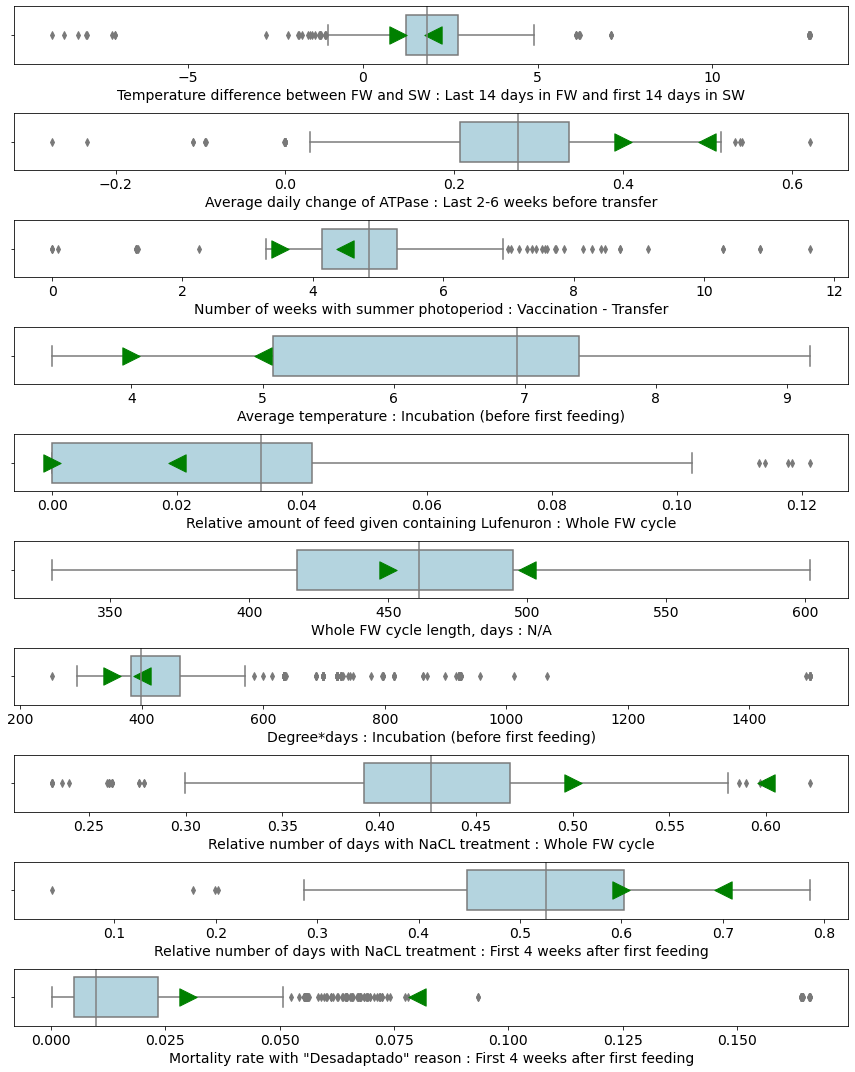

In [20]:
i=-1
# Create a single figure and axis outside the loop
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(12, 15))
showfliers = True

for i, f in enumerate(df_sorted.factor[:10]):
    factor_data = factors_targets[f]
    
    # Use the corresponding axis for each box plot
    ax = axes[i]
    
    sns.boxplot(data=factor_data, width=0.7, palette=["lightblue"], showfliers=showfliers, orient='h', zorder=0, ax=ax)

    optimal_left = optimal_ranges[f][0]
    optimal_right = optimal_ranges[f][1]

    ax.scatter([optimal_left], [0], c='green', marker='>', s=300, zorder=1)
    ax.scatter([optimal_right], [0], c='green', marker='<', s=300, zorder=1)
    
    # Add a median vertical line
    median_value = factor_data.median()
    ax.axvline(median_value, color='grey', linestyle='-', label='Median', zorder=2)

    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.set_yticklabels([])
    ax.set_xlabel(factor_names_normal[i], size=font_size)

plt.tight_layout()
plt.savefig(vis_path+f'unified_boxplot_with_optimal_range_UPD.jpg',dpi=300)
# plt.show()

C:\Users\fckmc\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
C:\Users\fckmc\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
C:\Users\fckmc\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
C:\Users\fckmc\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
C:\Users\fckmc\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
C:\Users\fckmc\AppDa

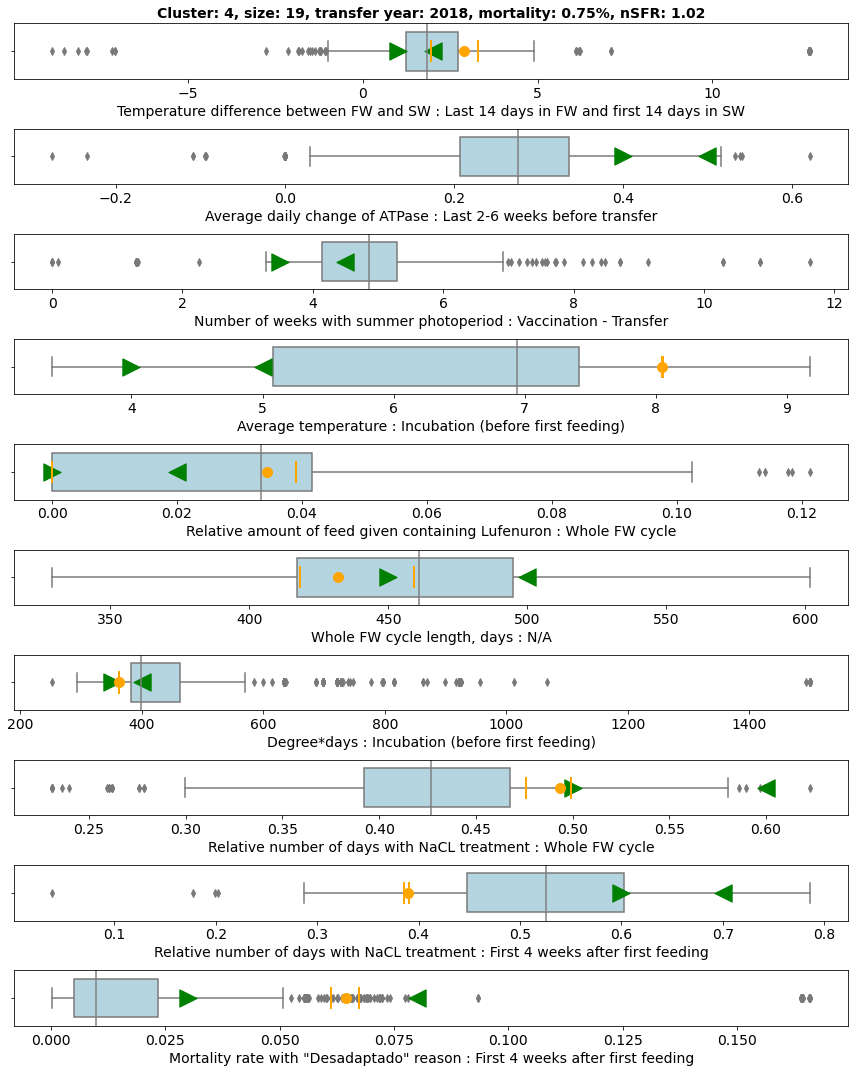

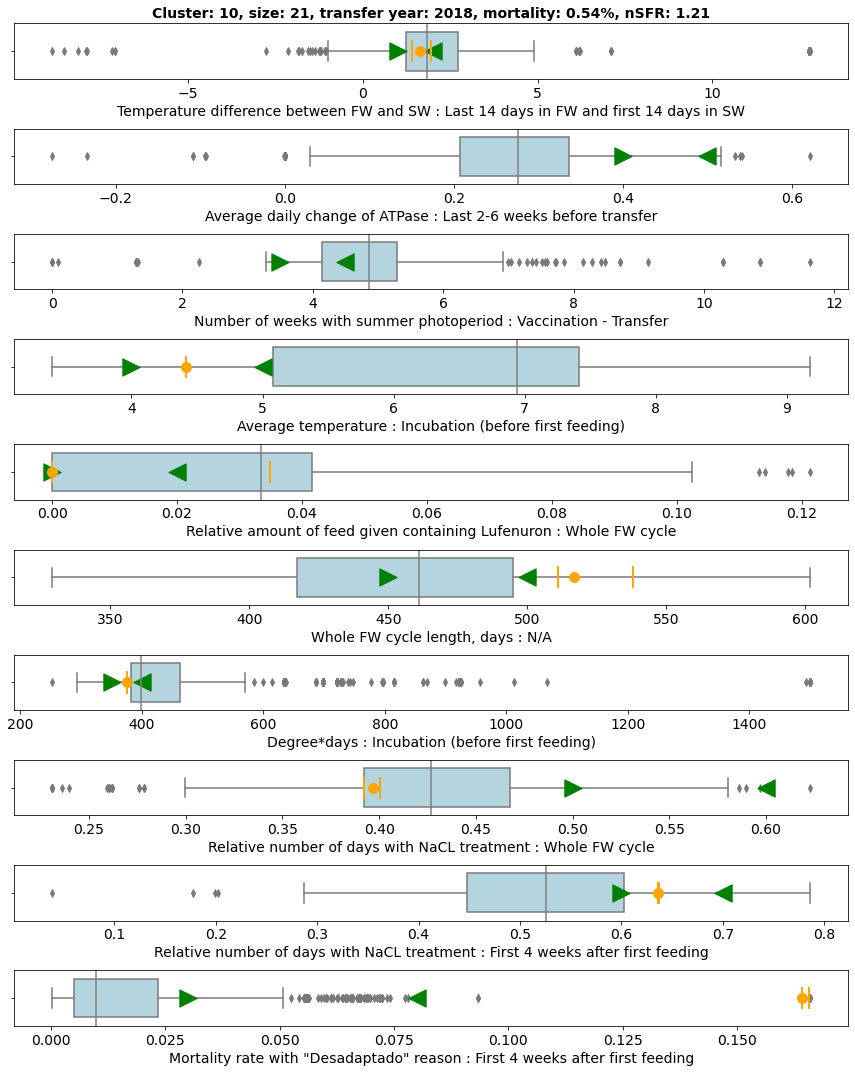

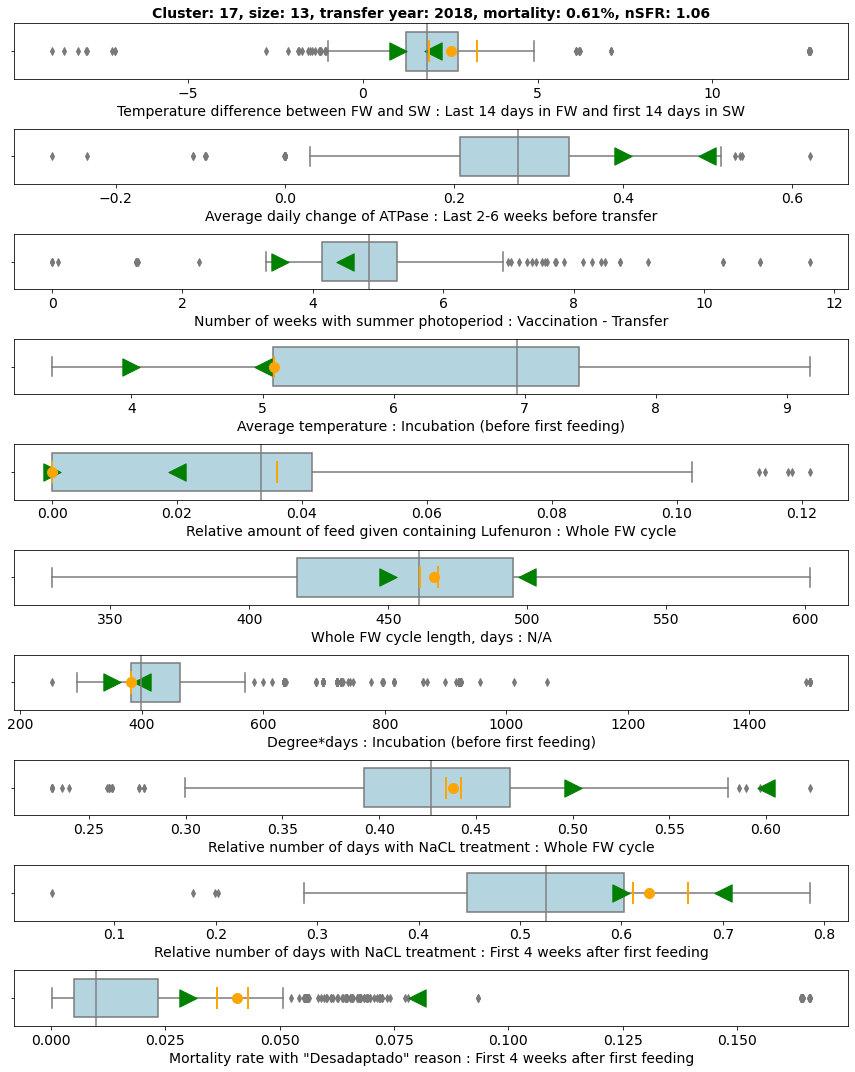

In [21]:
# i=-1
# cluster_name= 4
for cluster_name in arr_cluster_names:
#     print(cluster_name)
    # Create a single figure and axis outside the loop
    fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(12, 15))
    showfliers = True
    cluster_medians=bc_medians__[bc_medians__.cluster==cluster_name]
    cluster_size=cluster_medians['count'].iloc[0]
    cluster_mortality=cluster_medians['total_mortality_perc_90_median'].iloc[0]
    cluster_nsfr=cluster_medians['nSFR_median'].iloc[0]
    cluster_year=cluster_medians['transfer_year_median'].iloc[0]


    for i, f in enumerate(df_sorted.factor[:10]):
        factor_data = factors_targets[f]

        # Use the corresponding axis for each box plot
        ax = axes[i]

        sns.boxplot(data=factor_data, width=0.7, palette=["lightblue"], showfliers=showfliers, orient='h', zorder=0, ax=ax)

        optimal_left = optimal_ranges[f][0]
        optimal_right = optimal_ranges[f][1]

        ax.scatter([optimal_left], [0], c='green', marker='>', s=300, zorder=1)
        ax.scatter([optimal_right], [0], c='green', marker='<', s=300, zorder=1)
        median_value = factor_data.median()
        ax.axvline(median_value, color='grey', linestyle='-', label='Median', zorder=2)
        if f+'_median' in cluster_medians.columns:
            cluster_value = cluster_medians[f+'_median'].iloc[0]
            ax.scatter([cluster_value], [0], c='orange', marker='o', s=100,zorder=1)
            q1 = cluster_medians[f+'_quantile_0.25'].iloc[0]
            q3 = cluster_medians[f+'_quantile_0.75'].iloc[0]
            ax.vlines([q1, q3], -0.2, 0.2, color='orange', linestyle='-', linewidth=2)
        ax.tick_params(axis='both', which='major', labelsize=font_size)
        ax.set_yticklabels([])
        ax.set_xlabel(factor_names_normal[i], size=font_size)
        if i==0: ax.set_title(f'Cluster: {int(cluster_name)}, size: {int(cluster_size)}, transfer year: {int(cluster_year)}, mortality: {cluster_mortality*100:.2f}%, nSFR: {cluster_nsfr:.2f}',fontsize=font_size, fontweight='bold')

    plt.tight_layout()
    plt.savefig(vis_path+f'cluster_{int(cluster_name)}_with_optimal_range_UPD.jpg',dpi=300)
    # plt.show()

In [37]:
vis_path

'../modeling/img/factor ranking/'

<Figure size 432x288 with 0 Axes>

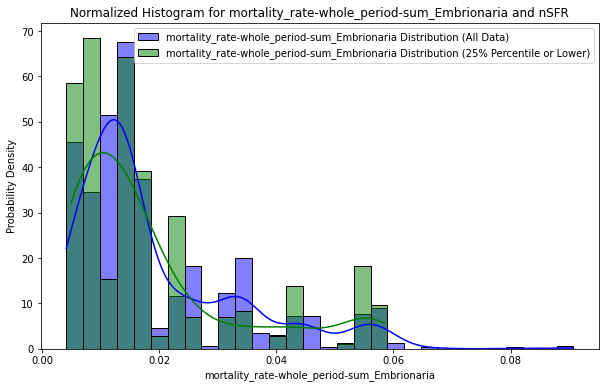

<Figure size 432x288 with 0 Axes>

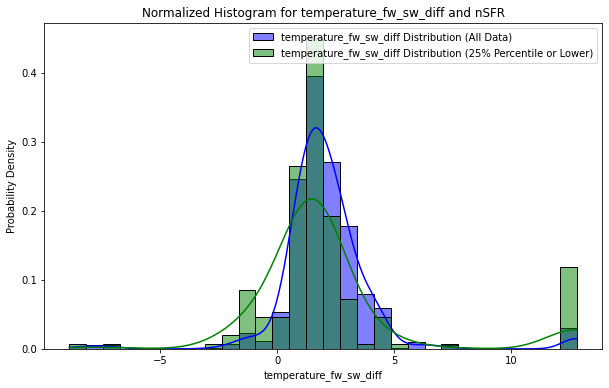

<Figure size 432x288 with 0 Axes>

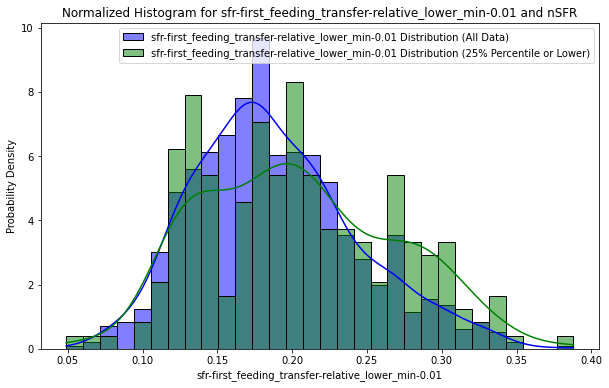

<Figure size 432x288 with 0 Axes>

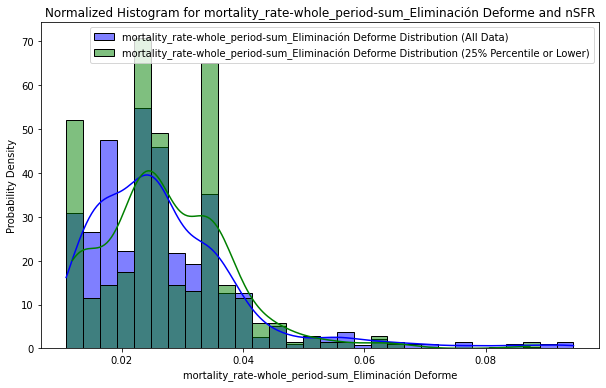

<Figure size 432x288 with 0 Axes>

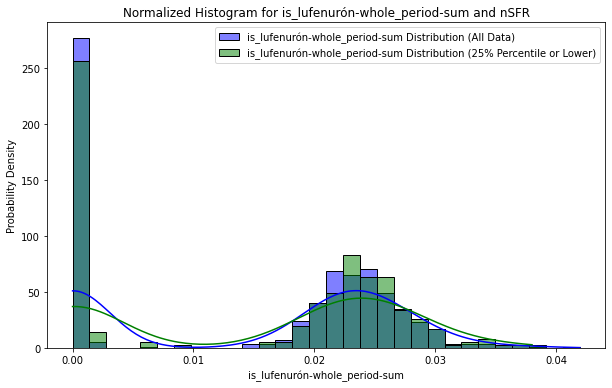

<Figure size 432x288 with 0 Axes>

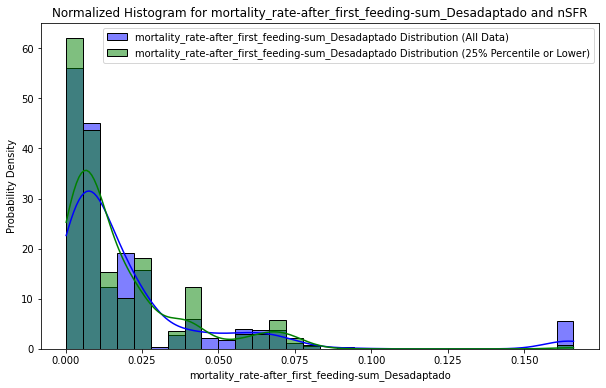

<Figure size 432x288 with 0 Axes>

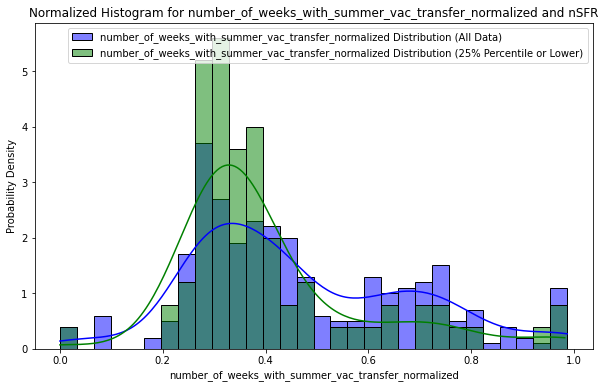

In [25]:
# target_col='nSFR'
# for factor_col in list(factor_list_nonnan)+['number_of_weeks_with_summer_vac_transfer_normalized']:
#     plt.figure()
#     # Get the data for the factor and target
#     # Get the data for the factor and target
#     factors_targets_ = factors_targets[[factor_col, target_col]].dropna()
#     factor_data = factors_targets_[factor_col]
#     target_data = factors_targets_[target_col]

#     # Calculate the 25th percentile of the target column
#     target_25th_percentile = np.percentile(target_data, 25)

#     # Sub-sample data corresponding to the lower 25% of target values
#     subsampled_factor_data = factor_data[target_data <= target_25th_percentile]

#     # Determine bin edges based on the combined data
#     combined_data = np.concatenate([factor_data, subsampled_factor_data])
#     min_value = combined_data.min()
#     max_value = combined_data.max()
#     bin_edges = np.linspace(min_value, max_value, num=31)  # Adjust the number of bins as needed

#     # Create normalized histograms with the same bin edges
#     plt.figure(figsize=(10, 6))
#     sns.histplot(factor_data, bins=bin_edges, kde=True, color='blue', label=f'{factor_col} Distribution (All Data)', stat='density')
#     sns.histplot(subsampled_factor_data, bins=bin_edges, kde=True, color='green', label=f'{factor_col} Distribution (25% Percentile or Lower)', stat='density')

#     # Add labels, title, and legend
#     plt.xlabel(factor_col)
#     plt.ylabel('Probability Density')
#     plt.title(f'Normalized Histogram for {factor_col} and {target_col}')
#     plt.legend()

#     # Save or show the plot
#     plt.savefig(vis_path+f'{target_col}_and_{factor_col}_normalized_histogram.jpg',dpi=300)
#     plt.show()

In [88]:
# scaler = RobustScaler()

# num_features = factors_targets_scaled.columns.difference(
#     ['mortality', 'tgc', 'non_existing', 'EW']
# ).tolist()
# cat_features = ['non_existing', 'EW']

# factors_targets_scaled = factors_targets.copy()
# factors_targets_scaled[num_features] = scaler.fit_transform(factors_targets_scaled[num_features])

## Factor Ranking

In [16]:
# df_iv_sorted.factor = ['Number of weeks with summer photoperiod over number of weeks, period since vaccination'
#             ,'Relative number of days with Baño sin pmv treatment, period 4 weeks after first feeding'
#             ,'Mortality rate with "Embrionaria" reason, period whole FW cycle'
#             ,'Max value of pH, period last 8 weeks'
#             ,'Temperature difference between FW and SW'
#             ,'Relative number of days with pH above 7.3, period last 8 weeks'
#             ,'Relative number of days with low SFR, period since first feeding till transfer'
#             ,'Mortality rate with "Eliminación Deforme" reason, period whole FW cycle'
#             ,'Relative number of days with "Lufenuron" treatment, period whole FW cycle'
#             ,'Mortality rate with "Desadaptado" reason, period 4 weeks after first feeding'
#             ]

,factor,IV,corr with mortality,corr with nSFR
0,number_of_weeks_with_summer_vac_transfer_norma...,0.074469,0.394876,0.127177
1,is_baño sin pmv-after_first_feeding-sum,0.060112,-0.245486,0.025391
2,mortality_rate-whole_period-sum_Embrionaria,0.029664,-0.015685,0.145912
3,ph-8_weeks_before_transfer-max,0.028686,-0.206254,0.132791
4,temperature_fw_sw_diff,0.026497,0.247707,-0.409721
5,ph-8_weeks_before_transfer-relative_higher_max...,0.025260,-0.164755,0.064348
6,sfr-first_feeding_transfer-relative_lower_min-...,0.024533,0.314433,-0.230718
7,mortality_rate-whole_period-sum_Eliminación De...,0.023946,0.069464,-0.017792
8,is_lufenurón-whole_period-sum,0.023350,0.033888,0.048443
9,mortality_rate-after_first_feeding-sum_Desadap...,0.023300,-0.263366,0.185695


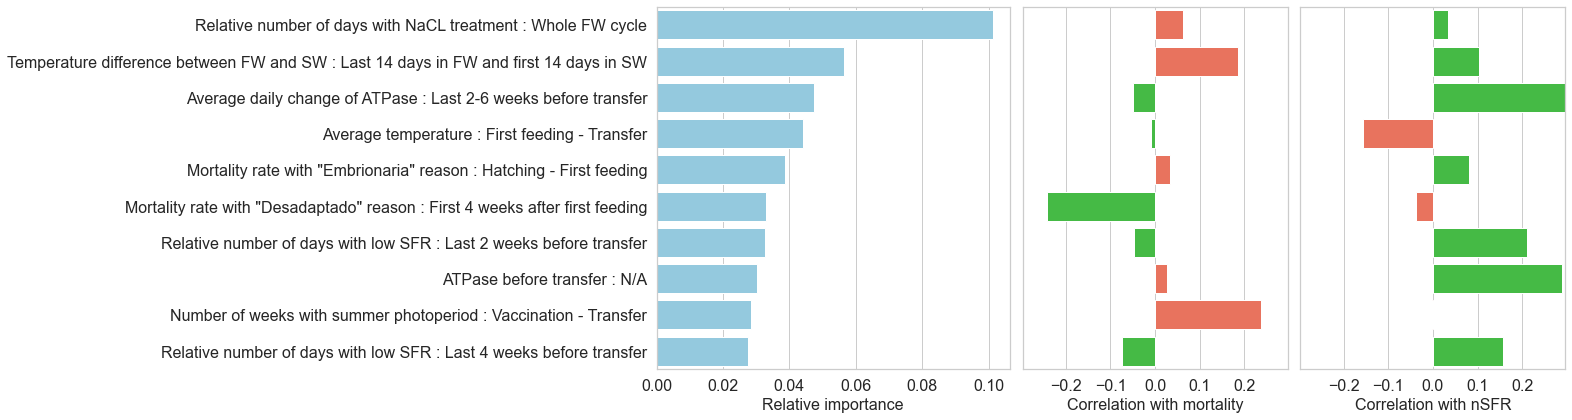

In [300]:
# # Sort the DataFrame by IV in descending order
# df_iv_sorted = df.sort_values(by="IV", ascending=False)[:10]
# df_iv_sorted = df_sorted.copy()[:10]
# # df_iv_sorted = df.sort_values(by="IV", ascending=False)
# df_iv_sorted['factor'] = factor_names_normal
# # df_iv_sorted.factor = ['Relative number of days with summer photoperiod, period since vaccination'
# #             ,'Relative number of days with low SFR, period since first feeding till transfer'
# #             ,'Temperature difference between FW and SW'
# #             ,'Mortality rate with "Eliminación Deforme" reason, period whole FW cycle'
# #             ,'Mortality rate with "Desadaptado" reason, period 4 weeks after first feeding'
# #             ,'Mortality rate with "Embrionaria" reason, period since hatching till first feeding'
# #             ,'Variation of ammonium, period last 4 weeks'
# #             ,'Temperature median value, period since first feeding till transfer'
# #             ,'Relative number of days with Bronopol treatment, period whole FW cycle'
# #             ,'Relative number of days with NaCL treatment, period 4 weeks after first feeding'
# #             ,'Relative amount of feed given containing Lufenuron, period since first feeding till transfer'
# #             ,'Cycle length, days, period since first movement till transfer'
# #             ,'Relative number of days with Cloramina treatment, period whole FW cycle'
# #             ,'Mortality rate, period last 6 weeks'
# #             ,'Relative amount of Biomar feed given, period since first feeding till transfer'
# #             ,'TGC, period last 8 weeks'
# #             ,'Number of days with rapid decrease (more than 50%) in feed amount, period whole FW cycle'
# #             ][:10]
# xlim_min = np.min([df_iv_sorted["corr with mortality"].min(),df_iv_sorted["corr with nSFR"].min()])
# xlim_max_ = np.max([df_iv_sorted["corr with mortality"].max(),df_iv_sorted["corr with nSFR"].max()])
# xlim_max=np.max([abs(xlim_min),abs(xlim_max_)])

# # Set the style
# sns.set(style="whitegrid")

# plt.figure(figsize=(22, 6))
# # plt.figure(figsize=(22, 11))
# font_size = 16
# # Create a grid with 1 row and 3 columns
# gs = gridspec.GridSpec(1, 3, width_ratios=[4, 3, 3])

# # First subplot: IV values
# plt.subplot(gs[0])
# sns.barplot(x="IV", y="factor", data=df_iv_sorted, color="skyblue")
# plt.yticks(fontsize=font_size)  # Increase y-tick font size
# plt.xticks(fontsize=font_size)
# # plt.title("IV Values", fontsize=font_size)
# plt.xlabel("Relative importance", fontsize=font_size)
# plt.ylabel("")

# # Second subplot: Correlation with mortality
# plt.subplot(gs[1])
# bar_colors_corr = df_iv_sorted["corr with mortality"].apply(lambda x: "tomato" if x > 0 else "limegreen")
# sns.barplot(x="corr with mortality", y="factor", data=df_iv_sorted, palette=bar_colors_corr)
# plt.yticks([])  # Remove y-axis labels
# plt.ylabel("")
# plt.xlim([-xlim_max, xlim_max])
# plt.xticks(fontsize=font_size)
# # plt.title("Correlation with mortality", fontsize=font_size)
# plt.xlabel("Correlation with mortality", fontsize=font_size)


# # Third subplot: Correlation with nSFR
# plt.subplot(gs[2])
# bar_colors_corr = df_iv_sorted["corr with nSFR"].apply(lambda x: "limegreen" if x > 0 else "tomato")
# sns.barplot(x="corr with nSFR", y="factor", data=df_iv_sorted, palette=bar_colors_corr)
# plt.yticks([])  # Remove y-axis labels
# plt.ylabel("")
# plt.xlim([-xlim_max, xlim_max])
# plt.xticks(fontsize=font_size)
# # plt.title("Correlation with nSFR", fontsize=font_size)
# plt.xlabel("Correlation with nSFR", fontsize=font_size)


# # Add space between subplots
# plt.tight_layout()

# # Show the plot
# # plt.show()
# plt.savefig('../Visualisation\\factor_ranking_v6_DE.png')
# # plt.savefig('../Visualisation\\factor_ranking_v5_full.png')

In [22]:
df_iv_sorted = df_sorted.copy()[:10]
df_iv_sorted

,factor,IV_x,corr with nSFR,IV_y,corr with mortality,IV
0,temperature_fw_sw_diff,0.194134,-0.237180,0.046992,0.201705,0.120563
1,atpasa_derivative,0.138630,0.142034,0.028755,NaN,0.083693
2,number_of_weeks_with_summer_vac_transfer,0.009929,NaN,0.138629,0.124851,0.074279
3,temperature_cleared-before_first_feeding-mean,0.050325,0.013996,0.082634,0.174179,0.066479
4,is_luf_weighted,0.088851,0.090367,0.043268,0.061349,0.066059
5,fw_cycle_length_first_mvmt_shipout,0.061330,-0.092679,0.043132,-0.019908,0.052231
6,temperature_cleared-before_first_feeding-degre...,0.039094,-0.037005,0.063762,-0.114564,0.051428
7,is_nacl-whole_period-sum,0.064480,0.205882,0.033546,0.052975,0.049013
8,is_nacl-after_first_feeding-sum,0.039836,0.149262,0.043224,-0.137388,0.041530
9,mortality_rate-after_first_feeding-sum_Desadap...,0.025819,0.087506,0.053868,-0.200142,0.039844


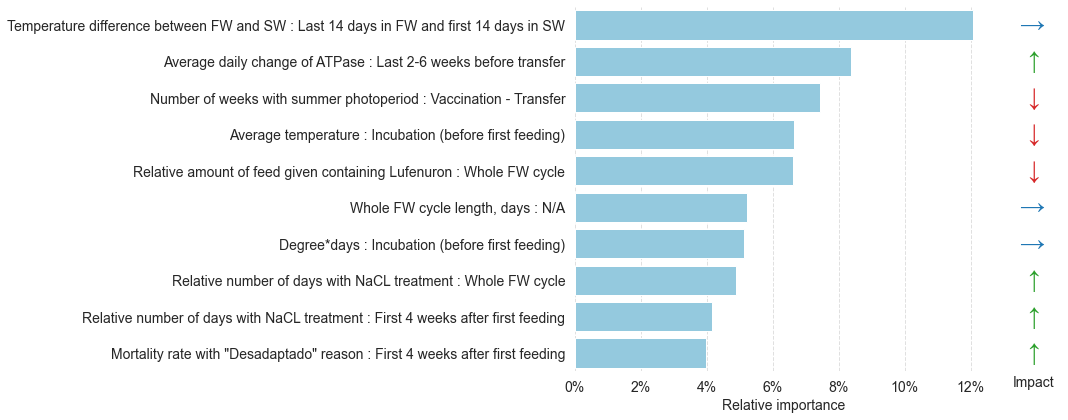

In [36]:
def percent_formatter(x, pos):
    return f"{x:.0%}"
# Set style and context with grid lines
sns.set_style("whitegrid")

plt.figure(figsize=(15, 6))
vis_path='../modeling/img/factor ranking/'
impact = [0,1,-1,-1,-1,0,0,1,1,1]
df_iv_sorted = df_sorted.copy()[:10]
df_iv_sorted['factor'] = factor_names_normal


# Create a grid with 1 row and 3 columns
gs = gridspec.GridSpec(1, 2, width_ratios=[15, 2])

# First subplot: IV values
plt.subplot(gs[0])
ax = sns.barplot(x="IV", y="factor", data=df_iv_sorted, color="skyblue")
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.xlabel("Relative importance", fontsize=font_size)
plt.ylabel("")
formatter = FuncFormatter(percent_formatter)
ax.xaxis.set_major_formatter(formatter)

ax.grid(axis="x", linestyle="--", alpha=0.6)

# Second subplot: Arrows based on impact values
plt.subplot(gs[1])
colors = ['tab:green' if val == 1 else 'tab:red' if val == -1 else 'tab:blue' for val in impact]
arrows = ['↑' if val == 1 else '↓' if val == -1 else '→' for val in impact]
sns.barplot(x=[1] * len(df_iv_sorted), y=df_iv_sorted['factor'], color='white')
sns.despine(left=True, right=True, top=True, bottom=True)  # Remove borders
for i, txt in enumerate(arrows):
    if txt=='→':
        plt.annotate(txt, (.25, i), va='center', ha='left', color='tab:blue', fontsize=25)
    elif txt=='↑': 
        plt.annotate(txt, (.4, i), va='center', ha='left', color='tab:green', fontsize=25)
    else:
        plt.annotate(txt, (.4, i), va='center', ha='left', color='tab:red', fontsize=25)
plt.yticks([])  # Remove y-axis labels for the second subplot
plt.xticks([])  # No x-axis ticks for the arrows subplot
# plt.xlim(-1, 1)  # Adjust the x-axis limits
plt.xlabel("Impact", fontsize=font_size)  # Adjust the label for the arrows subplot
plt.ylabel("")  # Adjust the label for the arrows subplot

plt.tight_layout()
# plt.show()
plt.savefig(vis_path+'factor_ranking_v8_with_arrows.png')